In [ ]:
#assumptions that will break if we use MCTS for play traces in this code
#1. Turn wont be either 0 or 1
#2. Cant just copy the final two rows to extend round number to maxNoOfRounds

In [2]:
import pandas as pd
import pdb
import math
import matplotlib.pyplot as plt
#from sklearn.manifold import MDS 
from sklearn.cluster import KMeans
import itertools
pd.set_option('display.max_rows', 50)

In [3]:
#parameters for round robin tournament
NOOFPLAYERS = 2 #note, keep this fixed and dont change it
games_per_matchup = 25
self_play = True
agents = ['BMWG', 'DW']

In [4]:
data  = pd.read_csv("data/featureslogfile.txt", sep = '\t')
print(data)

      GameID  Player  Round  Turn  CurrentScore  SCORE  SCORE_ADV  ORDINAL  \
0        2.0     0.0    0.0   0.0           3.0   0.06       0.00      0.5   
1        2.0     1.0    0.0   0.0           3.0   0.06       0.00      0.5   
2        2.0     0.0    0.0   1.0           3.0   0.06       0.00      0.5   
3        2.0     1.0    0.0   1.0           3.0   0.06       0.00      0.5   
4        2.0     0.0    1.0   0.0           3.0   0.06       0.00      0.5   
...      ...     ...    ...   ...           ...    ...        ...      ...   
8693   101.0     1.0   20.0   0.0          30.0   0.60       0.20      0.5   
8694   101.0     0.0   20.0   1.0          25.0   0.50      -0.32      1.0   
8695   101.0     1.0   20.0   1.0          33.0   0.66       0.32      0.5   
8696   101.0     0.0   21.0   0.0          31.0   0.62      -0.08      1.0   
8697   101.0     1.0   21.0   0.0          33.0   0.66       0.08      0.5   

      OUR_TURN  HAS_WON  ...  MINE  SENTRY  WITCH  ARTISAN  Pla

In [5]:
#define columns of interest 
card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
cols = ['AgentName', 'Player', 'GameID', 'Round', 'CurrentScore']
cols = cols + card_types_BigMoneyWithGardens_vs_DoubleWitch

In [6]:
#we seem to have an issue with some cards having their number reduced, which shouldn't happen in our set-up
for card in card_types_BigMoneyWithGardens_vs_DoubleWitch:
    for game in data['GameID'].unique():
        for player in data['Player'].unique():
            card_evol = data[(data['GameID'] == game) & (data['Player'] == player) & (data['Turn'] == 1)][card]
            card_delta = card_evol - card_evol.shift(1)
            if card_delta.min() < 0:
                print("Issue with " + str(card) + " in game " + str(game) + " with player " + str(player))
                
#problem_trace = data[(data['GameID'] == 27) & (data['Player'] == 1)]['WITCH']
#print(problem_trace)

Issue with WITCH in game 27.0 with player 1.0
Issue with WITCH in game 30.0 with player 1.0
Issue with WITCH in game 38.0 with player 1.0
Issue with WITCH in game 43.0 with player 1.0
Issue with WITCH in game 77.0 with player 1.0
Issue with WITCH in game 78.0 with player 1.0
Issue with WITCH in game 79.0 with player 1.0
Issue with WITCH in game 84.0 with player 1.0
Issue with WITCH in game 85.0 with player 1.0
Issue with WITCH in game 88.0 with player 1.0
Issue with WITCH in game 92.0 with player 1.0
Issue with WITCH in game 99.0 with player 1.0
Issue with WITCH in game 100.0 with player 1.0


In [7]:
#label all games with corresponding agent names

#first generate match-ups
matchups = []
if self_play:
    for agent1 in agents:
        for agent2 in agents:
            matchups.append((agent1, agent2))
else:
    matchups = list(itertools.permutations(agents, 2))
    
#function to map gameID to match-up
def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
    game_group = int((game_id - min_game_id)/no_games_per_matchup)
    matchup = matchup_list[game_group]
    agent1, agent2 = matchup
    if player_no == 0:
        return agent1
    else:
        return agent2
        
#add agent names to data set
min_GameID = data['GameID'].min()
data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [8]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
print(data['Turn'].unique())
data = data[data['Turn'] == 1]

[0. 1.]


In [9]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

     AgentName  Player  GameID  Round  CurrentScore  GARDENS  WITCH  CURSE  \
2         BMWG     0.0     2.0    0.0           3.0      0.0    0.0    0.0   
3         BMWG     1.0     2.0    0.0           3.0      0.0    0.0    0.0   
6         BMWG     0.0     2.0    1.0           3.0      0.0    0.0    0.0   
7         BMWG     1.0     2.0    1.0           3.0      0.0    0.0    0.0   
10        BMWG     0.0     2.0    2.0           3.0      0.0    0.0    0.0   
...        ...     ...     ...    ...           ...      ...    ...    ...   
8687        DW     1.0   101.0   18.0          29.0      0.0    2.0    4.0   
8690        DW     0.0   101.0   19.0          24.0      0.0    2.0    6.0   
8691        DW     1.0   101.0   19.0          30.0      0.0    2.0    4.0   
8694        DW     0.0   101.0   20.0          25.0      0.0    2.0    6.0   
8695        DW     1.0   101.0   20.0          33.0      0.0    2.0    4.0   

      PROVINCE  DUCHY  ESTATE  GOLD  SILVER  COPPER  
2        

In [10]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

31


In [11]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [12]:
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, NOOFPLAYERS).reset_index(drop = True)
print(extended_traces)

     AgentName  Player  GameID  Round  CurrentScore  GARDENS  WITCH  CURSE  \
0         BMWG     0.0     2.0    0.0           3.0      0.0    0.0    0.0   
1         BMWG     1.0     2.0    0.0           3.0      0.0    0.0    0.0   
2         BMWG     0.0     2.0    1.0           3.0      0.0    0.0    0.0   
3         BMWG     1.0     2.0    1.0           3.0      0.0    0.0    0.0   
4         BMWG     0.0     2.0    2.0           3.0      0.0    0.0    0.0   
...        ...     ...     ...    ...           ...      ...    ...    ...   
6195        DW     1.0   101.0   28.0          33.0      0.0    2.0    4.0   
6196        DW     0.0   101.0   29.0          25.0      0.0    2.0    6.0   
6197        DW     1.0   101.0   29.0          33.0      0.0    2.0    4.0   
6198        DW     0.0   101.0   30.0          25.0      0.0    2.0    6.0   
6199        DW     1.0   101.0   30.0          33.0      0.0    2.0    4.0   

      PROVINCE  DUCHY  ESTATE  GOLD  SILVER  COPPER  
0        

In [24]:
#next we need to flatten this dataframe so that each trace is a single row.
#Note we drop the current score as we dont need it for now. We also drop the round label as it is redundant
#and it will get reintroduced when flattening through the revised column names
traces_tmp = extended_traces.drop(['CurrentScore', 'Round'], axis = 1)
cols = [card_types_BigMoneyWithGardens_vs_DoubleWitch[i] + "_R" + str(r) 
        for r in range(0, maxNoOfRounds) for i in range(0, len(card_types_BigMoneyWithGardens_vs_DoubleWitch))] 

extended_traces_flat = traces_tmp.groupby(['AgentName', 'Player', 'GameID']).apply(lambda df: df[card_types_BigMoneyWithGardens_vs_DoubleWitch].values.flatten())
extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
extended_traces_flat = pd.concat([extended_traces_flat[['AgentName', 'Player', 'GameID']], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
extended_traces_flat.columns = ['AgentName', 'Player', 'GameID'] + cols

#note we also add the name of the agent of the opponent for each trace (this is used later when grouping play traces)
extended_traces_flat['Opponent'] = extended_traces_flat.apply(lambda row: 1.0 if row['Player'] == 0.0 else 0.0, axis = 1)
extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: gameID_to_matchup(row['GameID'], row['Opponent'], matchups, games_per_matchup, min_GameID), axis = 1)                                   

print(extended_traces_flat)

    AgentName  Player  GameID  GARDENS_R0  WITCH_R0  CURSE_R0  PROVINCE_R0  \
0        BMWG     0.0     2.0         0.0       0.0       0.0          0.0   
1        BMWG     0.0     3.0         0.0       0.0       0.0          0.0   
2        BMWG     0.0     4.0         0.0       0.0       0.0          0.0   
3        BMWG     0.0     5.0         0.0       0.0       0.0          0.0   
4        BMWG     0.0     6.0         0.0       0.0       0.0          0.0   
..        ...     ...     ...         ...       ...       ...          ...   
195        DW     1.0    97.0         0.0       0.0       0.0          0.0   
196        DW     1.0    98.0         0.0       1.0       0.0          0.0   
197        DW     1.0    99.0         0.0       0.0       0.0          0.0   
198        DW     1.0   100.0         0.0       0.0       0.0          0.0   
199        DW     1.0   101.0         0.0       0.0       0.0          0.0   

     DUCHY_R0  ESTATE_R0  GOLD_R0  ...  WITCH_R30  CURSE_R30  P

In [25]:
#comparing two distinct games we have:
#1. Game 1 player 1 - denoted by G1_P1
#2. Game 1 player 2 - denoted by G1_P2
#3. Game 2 player 1 - denoted by G2_P1
#4. Game 2 player 2 - denoted by G2_P2

#then the possible combinations of play traces to compare between two games are as follows:
#1. "G1_P1 (with opponent G1_P2)" versus "G2_P1 (with opponent G2_P2)"
#2. "G1_P1 (with opponent G1_P2)" versus "G2_P2 (with opponent G2_P1)"
#3. "G1_P2 (with opponent G1_P1)" versus "G2_P1 (with opponent G2_P2)"
#3. "G1_P2 (with opponent G1_P1)" versus "G2_P2 (with opponent G2_P1)"

#within a single game we can only compare the traces of player 1 and player 2

noOfGames = extended_traces_flat['GameID'].unique().size
noOfOffDiagGameCombos = int(noOfGames *(noOfGames -1)/2.0) 
noOfPairWiseDistances = 4 * noOfOffDiagGameCombos + noOfGames
print(noOfPairWiseDistances)

19900


In [26]:
#next we need to collect together all pairwise combinations of traces so that we can compute all distance measure pairs

# Step 1: Create a list of DataFrames for each 'off diagonal' combination of games
unique_values = extended_traces_flat['GameID'].unique()
offdiag_combinations = list(itertools.combinations(unique_values, 2))
diag_combos = [(i,i) for i in unique_values]
combos = offdiag_combinations + diag_combos

list_dfs = []
for combination in combos:
    #extract traces for each game ID and strategy combination
    GameID_1, GameID_2 = combination
    keys = []
    #label player numbers for clarity
    player1_game1 = 0
    player2_game1 = 1
    player1_game2 = 0
    player2_game2 = 1
    if GameID_1 != GameID_2:
        #define the four combinations of play traces we can compare between two 'off diagonal' games
        keys = [((GameID_1, player1_game1), (GameID_2, player1_game2)),
                ((GameID_1, player1_game1), (GameID_2, player2_game2)),
                ((GameID_1, player2_game1), (GameID_2, player1_game2)),
                ((GameID_1, player2_game1), (GameID_2, player2_game2 ))]
    else:
        keys = [((GameID_1, player1_game1), (GameID_1, player2_game1))]
             
    for key in keys:
        key1, key2 = key
        
        count= 0;
        df_inter = [];
        for game_player in [key1,key2]:
            count += 1
            tag = "_P" + str(count)
            game,player = game_player
        
            df = extended_traces_flat[(extended_traces_flat['GameID'] == game) & (extended_traces_flat['Player'] == player)]
            new_col_names = {old_col: old_col + tag for old_col in extended_traces_flat.columns}
            df = df.rename(columns=new_col_names)
            
            #store to prepare for concatenation
            df_inter.append(df)
            
        #next align play traces by concatenating 
        df_trace = pd.concat([df_inter[0], df_inter[1].set_index(df_inter[0].index)], axis = 1)
        
        #then add to list of dfs
        list_dfs.append(df_trace)
        
#finally we need to append togther all the datafarmes in our list
sym_trace_combos_flat = pd.concat(list_dfs, ignore_index=True)

In [27]:
#the no of rows in our symmetric trace combos should be given by noOfPairwiseDistances 
#and no columns should be given by the card types * no of rounds plus 5 (for player, player name, gameID, opponent and
#opponent name) all mulitplied by two, for the two players
print("Expected no rows: " + str(noOfPairWiseDistances))
print("Expected no of cols: " + str((len(card_types_BigMoneyWithGardens_vs_DoubleWitch)*maxNoOfRounds +5)*2))
sym_trace_combos_flat.shape

Expected no rows: 19900
Expected no of cols: 568


(19900, 568)

In [29]:
#next step is to calculate the distance between each pairwise play trace
def dist_measure(playTracePair, cardTypes, maxRounds, tag1, tag2):
    dist = 0
    for r in range(0, maxRounds):
        for card in cardTypes:
            col1 = card + "_R" + str(r) + tag1
            col2 = card + "_R" + str(r) + tag2
            dist += (playTracePair[col1]-playTracePair[col2])**2
    dist = math.sqrt(dist)
    return dist

In [30]:
#now compute all the pairwise trace distances
sym_trace_combos_flat['dist'] = sym_trace_combos_flat.apply(lambda row: dist_measure(row, card_types_BigMoneyWithGardens_vs_DoubleWitch,
                                                                                    maxNoOfRounds, "_P1", "_P2"), axis = 1)
print(sym_trace_combos_flat)

      AgentName_P1  Player_P1  GameID_P1  GARDENS_R0_P1  WITCH_R0_P1  \
0             BMWG        0.0        2.0            0.0          0.0   
1             BMWG        0.0        2.0            0.0          0.0   
2             BMWG        1.0        2.0            0.0          0.0   
3             BMWG        1.0        2.0            0.0          0.0   
4             BMWG        0.0        2.0            0.0          0.0   
...            ...        ...        ...            ...          ...   
19895           DW        0.0       97.0            0.0          0.0   
19896           DW        0.0       98.0            0.0          0.0   
19897           DW        0.0       99.0            0.0          0.0   
19898           DW        0.0      100.0            0.0          0.0   
19899           DW        0.0      101.0            0.0          0.0   

       CURSE_R0_P1  PROVINCE_R0_P1  DUCHY_R0_P1  ESTATE_R0_P1  GOLD_R0_P1  \
0              0.0             0.0          0.0           

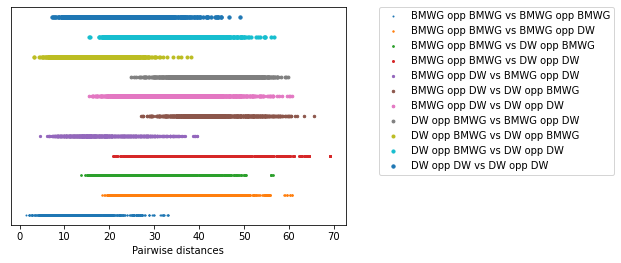

In [49]:
#TODO: how do I deal with symmetric case again?

#plot distances along the real line and colour code
count = 0;
for name, group in sym_trace_combos_flat.groupby(['AgentName_P1', 'AgentNameOpponent_P1', 'AgentName_P2', 'AgentNameOpponent_P2']):
    p1, opp1, p2, opp2 = name
    leg_label = p1 + " opp " + opp1 + " vs " + p2 + " opp " + opp2
    plt.scatter(group['dist'], [count * 0.01] * group['dist'].shape[0], s = count + 1, label = leg_label)
    count += 1
    
plt.yticks([])
plt.xlabel('Pairwise distances')
plt.legend(loc = (1.1,0.23))


In [32]:
#next we look at the average and standard deviation of distances between play traces grouped by the strategy 
#of the player and the opponent
mean_and_std = sym_trace_combos_flat.groupby(['AgentName_P1','AgentNameOpponent_P1',
                                                  'AgentName_P2','AgentNameOpponent_P2'])['dist'].agg(['mean', 'std','count']).reset_index()
print(mean_and_std)

   AgentName_P1 AgentNameOpponent_P1 AgentName_P2 AgentNameOpponent_P2  \
0          BMWG                 BMWG         BMWG                 BMWG   
1          BMWG                 BMWG         BMWG                   DW   
2          BMWG                 BMWG           DW                 BMWG   
3          BMWG                 BMWG           DW                   DW   
4          BMWG                   DW         BMWG                   DW   
5          BMWG                   DW           DW                 BMWG   
6          BMWG                   DW           DW                   DW   
7            DW                 BMWG         BMWG                   DW   
8            DW                 BMWG           DW                 BMWG   
9            DW                 BMWG           DW                   DW   
10           DW                   DW           DW                   DW   

         mean       std  count  
0   12.690875  6.081592   1225  
1   35.383917  7.551876   2500  
2   28.71090

In [33]:
#why do we have "BMWG (with opponent DW)" vs "DW (with opponent BM)" and also "DW (with opponent BM)" vs "BMWG (with opponent DW)"?
#this is because we have two games BM1 vs DW1 and BM2 vs DW2, then we have BM1 vs DW2 and also DW1 vs BM2, which looks symmetric
#and irrelevant but is actually a valid comparison. We also only have this symmetry when we are comparing two games, 
#within which each player has different strategies (but the same strategies across the two games), i.e A1 vs B1 and A2 vs B2, hence 
#why we only see the one extra group in the above results set
trace_set1 = sym_trace_combos_flat[(sym_trace_combos_flat['AgentName_P1'] == 'BMWG') & (sym_trace_combos_flat['AgentNameOpponent_P1'] == 'DW') 
                                  & (sym_trace_combos_flat['AgentName_P2'] == 'DW') & (sym_trace_combos_flat['AgentNameOpponent_P2'] == 'BMWG')]
trace_set2 = sym_trace_combos_flat[(sym_trace_combos_flat['AgentName_P1'] == 'DW') & (sym_trace_combos_flat['AgentNameOpponent_P1'] == 'BMWG') 
                                  & (sym_trace_combos_flat['AgentName_P2'] == 'BMWG') & (sym_trace_combos_flat['AgentNameOpponent_P2'] == 'DW')]

#now compare the set of games investigated
example1 = trace_set1[['GameID_P1', 'GameID_P2', 'AgentName_P1','AgentNameOpponent_P1', 'AgentName_P2','AgentNameOpponent_P2', 'dist']][0:5]
example2 = trace_set2[['GameID_P1', 'GameID_P2', 'AgentName_P1','AgentNameOpponent_P1', 'AgentName_P2','AgentNameOpponent_P2', 'dist']][0:5]

#in these examples we see different distance values showing that these are valid trace comparisons and not a double
#counting
print(example1)
print(example2)

      GameID_P1  GameID_P2 AgentName_P1 AgentNameOpponent_P1 AgentName_P2  \
8701       27.0       28.0         BMWG                   DW           DW   
8705       27.0       29.0         BMWG                   DW           DW   
8709       27.0       30.0         BMWG                   DW           DW   
8713       27.0       31.0         BMWG                   DW           DW   
8717       27.0       32.0         BMWG                   DW           DW   

     AgentNameOpponent_P2       dist  
8701                 BMWG  39.051248  
8705                 BMWG  39.420807  
8709                 BMWG  40.496913  
8713                 BMWG  45.475268  
8717                 BMWG  41.496988  
      GameID_P1  GameID_P2 AgentName_P1 AgentNameOpponent_P1 AgentName_P2  \
8702       27.0       28.0           DW                 BMWG         BMWG   
8706       27.0       29.0           DW                 BMWG         BMWG   
8710       27.0       30.0           DW                 BMWG         BMW

In [34]:
#next we aggregate those cases play traces comparisons that are identical under interchange 
#of the P1 and P2 tags (nothing special about player 1 vs player 2 and hence keeping those 
#groups split out)
mean_and_std_agg = mean_and_std.copy()
removed_rows = []
for index1 in mean_and_std_agg.index:
    if (index1 not in removed_rows):
        agent_p1_index1 = mean_and_std_agg['AgentName_P1'].loc[index1]
        agentopp_p1_index1 = mean_and_std_agg['AgentNameOpponent_P1'].loc[index1]
        agent_p2_index1 = mean_and_std_agg['AgentName_P2'].loc[index1]
        agentopp_p2_index1 = mean_and_std_agg['AgentNameOpponent_P2'].loc[index1]
        for index2 in mean_and_std_agg.index:
            #print("Index1 :" + str(index1) + " Index2: " + str(index2))
            if (index2 != index1):
                if (index2 not in removed_rows):
                    agent_p1_index2 = mean_and_std_agg['AgentName_P1'].loc[index2]
                    agentopp_p1_index2 = mean_and_std_agg['AgentNameOpponent_P1'].loc[index2]
                    agent_p2_index2 = mean_and_std_agg['AgentName_P2'].loc[index2]
                    agentopp_p2_index2 = mean_and_std_agg['AgentNameOpponent_P2'].loc[index2]
                    #now check for symmetry
                    if ((agent_p1_index1 == agent_p2_index2) 
                        & (agent_p2_index1 == agent_p1_index2)
                        & (agentopp_p1_index1 == agentopp_p2_index2) 
                        & (agentopp_p2_index1 == agentopp_p1_index2)):
                        #then combine the rows
                        mean1 = mean_and_std_agg['mean'].loc[index1]
                        count1 = mean_and_std_agg['count'].loc[index1]
                        mean2 = mean_and_std_agg['mean'].loc[index2]
                        count2 = mean_and_std_agg['count'].loc[index2]
                        std1 = mean_and_std_agg['std'].loc[index1]
                        std2 = mean_and_std_agg['std'].loc[index2]
                        mean_and_std_agg['mean'].loc[index1] = (mean1 * count1 + mean2*count2)/(count1 + count2)
                        mean_and_std_agg['std'].loc[index1] = math.sqrt((math.pow(std1,2) * count1 + math.pow(std2,2)*count2)/(count1 + count2))
                        mean_and_std_agg['count'].loc[index1] = count1 + count2
                        mean_and_std_agg = mean_and_std_agg.drop(index2, axis = 0)
                        removed_rows.append(index2)
            
print(mean_and_std_agg)

   AgentName_P1 AgentNameOpponent_P1 AgentName_P2 AgentNameOpponent_P2  \
0          BMWG                 BMWG         BMWG                 BMWG   
1          BMWG                 BMWG         BMWG                   DW   
2          BMWG                 BMWG           DW                 BMWG   
3          BMWG                 BMWG           DW                   DW   
4          BMWG                   DW         BMWG                   DW   
5          BMWG                   DW           DW                 BMWG   
6          BMWG                   DW           DW                   DW   
8            DW                 BMWG           DW                 BMWG   
9            DW                 BMWG           DW                   DW   
10           DW                   DW           DW                   DW   

         mean       std  count  
0   12.690875  6.081592   1225  
1   35.383917  7.551876   2500  
2   28.710909  6.941454   2500  
3   39.493401  8.364789   2500  
4   18.832497  6.867

/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_94040/4029290965.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_and_std_agg['mean'].loc[index1] = (mean1 * count1 + mean2*count2)/(count1 + count2)
/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_94040/4029290965.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_and_std_agg['std'].loc[index1] = math.sqrt((math.pow(std1,2) * count1 + math.pow(std2,2)*count2)/(count1 + count2))
/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_94040/4029290965.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [38]:
#next we compute the average traces for each combination of players and opponents, this 
#allows us to compare to the centroids computed by k-means clustering (note this is only 
#useful when we know what strategies are being employed by our AI agents or players, and 
#is used to sense check K-means in our base case scenarios)

flat_trace_tmp = extended_traces_flat.drop(['Player', 'GameID'], axis = 1)
average_traces = flat_trace_tmp.groupby(['AgentName','AgentNameOpponent']).apply(lambda row: round(row.mean())).reset_index()
new_col_names = {old_col: old_col + '_avg' for old_col in average_traces.columns[2:]}
average_traces.rename(columns = new_col_names, inplace = True)
print(average_traces)

  AgentName AgentNameOpponent  GARDENS_R0_avg  WITCH_R0_avg  CURSE_R0_avg  \
0      BMWG              BMWG             0.0           0.0           0.0   
1      BMWG                DW             0.0           0.0           0.0   
2        DW              BMWG             0.0           0.0           0.0   
3        DW                DW             0.0           0.0           0.0   

   PROVINCE_R0_avg  DUCHY_R0_avg  ESTATE_R0_avg  GOLD_R0_avg  SILVER_R0_avg  \
0              0.0           0.0            3.0          0.0            1.0   
1              0.0           0.0            3.0          0.0            1.0   
2              0.0           0.0            3.0          0.0            1.0   
3              0.0           0.0            3.0          0.0            1.0   

   ...  GARDENS_R30_avg  WITCH_R30_avg  CURSE_R30_avg  PROVINCE_R30_avg  \
0  ...              1.0            0.0            0.0               4.0   
1  ...              3.0            0.0            7.0               

/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_94040/2224071149.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_traces = flat_trace_tmp.groupby(['AgentName','AgentNameOpponent']).apply(lambda row: round(row.mean())).reset_index()


In [ ]:
#next calculate the distance between every play trace and the average traces
dist_to_averages = {}
for player in ['BigMoneyWithGardens','DoubleWitch']:
    avg_trace = average_traces[average_traces['AverageTraceForStrategy'] == player].drop('AverageTraceForStrategy', axis = 1)
    avg_trace = pd.concat([avg_trace]*len(extended_traces_flat), ignore_index = True)
    avg_trace.reset_index()
    extended_traces_flat.reset_index()
    trace_pairs_to_avg = pd.concat([extended_traces_flat, avg_trace], axis = 1)

    #now we can compute the distance
    trace_pairs_to_avg['dist'] = trace_pairs_to_avg.apply(lambda row: dist_measure(row, card_types_BigMoneyWithGardens_vs_DoubleWitch,
                                                                                        maxNoOfRounds, "", "_avg"), axis = 1)
    #calculate averages and standard deviations
    trace_pairs_to_avg = trace_pairs_to_avg[['PlayerName','dist']]
    averages = trace_pairs_to_avg.groupby('PlayerName').mean()
    stds = trace_pairs_to_avg.groupby('PlayerName').std()
    
    print("Results when average trace is from " + player + ":")
    print(averages)
    print(stds)
    
    dist_to_averages[player] = trace_pairs_to_avg

In [ ]:
#plot distances to average traces along the real line and colour coded
dists_BMWG_AvgBMWG = dist_to_averages['BigMoneyWithGardens'][dist_to_averages['BigMoneyWithGardens']['PlayerName'] == 'BigMoneyWithGardens']
dists_DW_AvgBMWG = dist_to_averages['BigMoneyWithGardens'][dist_to_averages['BigMoneyWithGardens']['PlayerName'] == 'DoubleWitch']
dists_BMWG_AvgDW = dist_to_averages['DoubleWitch'][dist_to_averages['BigMoneyWithGardens']['PlayerName'] == 'BigMoneyWithGardens']
dists_DW_AvgDW = dist_to_averages['DoubleWitch'][dist_to_averages['BigMoneyWithGardens']['PlayerName'] == 'DoubleWitch']
plt.scatter(dists_BMWG_AvgBMWG['dist'], [0] * dists_BMWG_AvgBMWG.shape[0], s = 2, label = 'BMWG - Avg. BMWG')
plt.scatter(dists_DW_AvgBMWG['dist'], [0.01] * dists_DW_AvgBMWG.shape[0], s = 2, label = 'DW - Avg. BMWG')
plt.scatter(dists_BMWG_AvgDW['dist'], [0.02] * dists_BMWG_AvgDW.shape[0], s = 2, label = 'BMWG - Avg. DW')
plt.scatter(dists_DW_AvgDW['dist'], [0.03] * dists_DW_AvgDW.shape[0], s = 2, label = 'DW - Avg. DW')
plt.yticks([])
plt.xlabel('Pairwise distances')
plt.legend(loc = (1.1,0.77))

In [ ]:
#next we want to apply k-means clustering with (euclidean distance measure) on our set of traces to see if we can 
#identify BM and DW strategies without apriori knowledge of their existence. 
trace_X = extended_traces_flat.drop(['PlayerName','Player','GameID'], axis = 1)
kmeans = KMeans(n_clusters=2, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(trace_X)

In [ ]:
#add kmeans cluster classifications of traces to dataframe and see how that aligns with AI agent strategies
extended_traces_flat['ClusterID'] = kmeans.labels_
strat_vs_clusterid = extended_traces_flat[['PlayerName','ClusterID']].drop_duplicates()
print(strat_vs_clusterid)

In [ ]:
#look at how the cluster centers compare to our average traces
df_cluster_centres = pd.DataFrame(kmeans.cluster_centers_)
cols = [card_types_BigMoneyWithGardens_vs_DoubleWitch[i] + "_R" + str(r) for r in range(0, maxNoOfRounds) 
        for i in range(0, len(card_types_BigMoneyWithGardens_vs_DoubleWitch))]
df_cluster_centres.columns = cols
#round entires to nearest integer (inline with how we define our average traces)
df_cluster_centres = df_cluster_centres.round(0)
print(df_cluster_centres)

In [ ]:
def deck_evol_comparison(trace1, trace2, tag1, tag2, cardTypes, maxRounds):
    #look at evolution of number of cards of each type per round
    noCardTypes = len(cardTypes)
    noOfSubplotsInXDirection = 3
    noOfSubplotsInYDirection = 3
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection)
    for i in range(0,3):
        for j in range(0,3):
            cardIndex = 3*j + i
            cardType = cardTypes[cardIndex]
            card_col_1 = [cardType + "_R" + str(r) + tag1 for r in range(0,maxRounds)]
            card_col_2 = [cardType + "_R" + str(r) + tag2 for r in range(0,maxRounds)]
            axs[i,j].plot(range(0,maxRounds), trace1[card_col_1].iloc[0], label = 'Trace_1')
            axs[i,j].plot(range(0,maxRounds), trace2[card_col_2].iloc[0], label = 'Trace_2')
            axs[i,j].set_title(cardType)
            axs[i,j].set_xlabel('Round')
            fig.tight_layout() 

In [ ]:
#compare centre with ClusterID zero which I am assuming corresponds to first row in outputted cluster centres
#with double witch average trace
cluster0centre = pd.DataFrame(df_cluster_centres.iloc[0]).transpose()
DW_avg_trace = average_traces[average_traces['AverageTraceForStrategy'] == 'DoubleWitch'].drop('AverageTraceForStrategy', axis =1)

deck_evol_comparison(cluster0centre, DW_avg_trace, "", "_avg", card_types_BigMoneyWithGardens_vs_DoubleWitch
                    ,maxNoOfRounds)

In [ ]:
#compare centre with ClusterID one which I am assuming corresponds to the second row in outputted cluster centres
#with BM average trace
cluster1centre = pd.DataFrame(df_cluster_centres.iloc[1]).transpose()
BMWG_avg_trace = average_traces[average_traces['AverageTraceForStrategy'] == 'BigMoneyWithGardens'].drop('AverageTraceForStrategy', axis =1)

deck_evol_comparison(cluster1centre, BMWG_avg_trace, "", "_avg", card_types_BigMoneyWithGardens_vs_DoubleWitch
                    ,maxNoOfRounds)

In [ ]:
#TODO:code not updated below this point

In [ ]:
#compute again our pairwise traces but this time also breakdown by opponent type
#pairTraceDistsGranular = sym_trace_combos[['GameID_1','GameID_2','PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2','dist']]
#pairTraceDistsGranular = sym_trace_combos.groupby(['GameID_1','GameID_2','PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2'])['dist'].sum()
#df_pairTraceDistsGranular = pairTraceDistsGranular.reset_index()
#print(df_pairTraceDistsGranular)

In [ ]:
#esults_means = pairTraceDistsGranular.groupby(['PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2']).mean()
#print(results_means)
#results_std = pairTraceDistsGranular.groupby(['PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2']).std()
#print(results_std)

In [ ]:
#what is happening with the large distance value for BM vs BM? i.e. why the large amount of variance?
#look at piarwise traces for smallest and largest distance values
#BMBM_data = df_pairwiseTraceDistances[(df_pairwiseTraceDistances['PlayerName_1'] == 'BigMoneyWithGardens') &
#                                        (df_pairwiseTraceDistances['PlayerName_2'] == 'BigMoneyWithGardens')]

#smallest_pairwise = BMBM_data.loc[BMBM_data['dist'].idxmin()]
#largest_pairwise = BMBM_data.loc[BMBM_data['dist'].idxmax()]
#print(smallest_pairwise)
#print(largest_pairwise)

In [ ]:
#def deck_evol_comparison(pairwise_deck_evols, cardTypes):
#    #look at evolution of number of cards of each type per round
#    noCardTypes = len(cardTypes)
#    noOfSubplotsInXDirection = 3
#    noOfSubplotsInYDirection = 3
#    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection)
#    for i in range(0,3):
#        for j in range(0,3):
#            cardIndex = 3*j + i
#            cardType = cardTypes[cardIndex]
#            card_col_1 = cardType + "_1"
#            card_col_2 = cardType + "_2"
#            axs[i,j].plot(pairwise_deck_evols['Round'], pairwise_deck_evols[card_col_1], label = 'Player_1')
#            axs[i,j].plot(pairwise_deck_evols['Round'], pairwise_deck_evols[card_col_2], label = 'Player_2')
#            axs[i,j].set_title(cardType)
#            axs[i,j].set_xlabel('Round')
#            fig.tight_layout() 

In [ ]:
#need to look at deck evolutions for each of these cases
#largest_pairwise_decks =  sym_trace_combos[(sym_trace_combos['GameID_1'] == largest_pairwise['GameID_1']) 
#                                           & (sym_trace_combos['GameID_2'] == largest_pairwise['GameID_2']) 
#                                           & (sym_trace_combos['PlayerName_1'] == largest_pairwise['PlayerName_1']) 
#                                           & (sym_trace_combos['PlayerName_2'] == largest_pairwise['PlayerName_2'])]
#smallest_pairwise_decks =  sym_trace_combos[(sym_trace_combos['GameID_1'] == smallest_pairwise['GameID_1']) 
#                                           & (sym_trace_combos['GameID_2'] == smallest_pairwise['GameID_2']) 
#                                           & (sym_trace_combos['PlayerName_1'] == smallest_pairwise['PlayerName_1']) 
#                                           & (sym_trace_combos['PlayerName_2'] == smallest_pairwise['PlayerName_2'])]
#print(largest_pairwise_decks['dist'].sum())
#print(smallest_pairwise_decks['dist'].sum())